# NSWClassifier

## Importing Packages

In [2]:
from mlots import NSWClassifier
from sklearn.model_selection import GridSearchCV
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline

In [3]:
font = {'size'   : 22}

matplotlib.rc('font', **font)

## Loading Data

Here we are loading the ``SyntheticControl`` dataset.  
The datasets are in two ``.arff`` files with pre-defined train and test splits.  
The following code reads the two files stores the ``X`` (time-series data) and ``y`` (labels), into their specific train and test sets.
***

In [5]:
name = "SyntheticControl"

dataset = arff.loadarff(f'../input/{name}/{name}_TRAIN.arff'.format(name=name))[0]
X_train = np.array(dataset.tolist(), dtype=np.float32)
y_train = X_train[: , -1]
X_train = X_train[:, :-1]

dataset = arff.loadarff(f'input/{name}/{name}_TEST.arff'.format(name=name))[0]
X_test = np.array(dataset.tolist(), dtype=np.float32)
y_test = X_test[: , -1]
X_test = X_test[:, :-1]

#Converting target from bytes to integer
y_train = [int.from_bytes(el, "little") for el in y_train]
y_test = [int.from_bytes(el, "little") for el in y_test]
X_train.shape, X_test.shape

((300, 60), (300, 60))

|Set|Sample size|TS length|
|:---|:----------|:-------|
|Train|300|60|
|Test|300|60|

## Evaluating NSW

### Default parameters

We would employ ``NSWClassifier`` model from the ``mlots`` python package.  
First, the model is evaluated with default parameters over the ``SyntheticControl`` dataset.
***

In [8]:
model_default = NSWClassifier(random_seed=42).fit(X_train,y_train)

100%|██████████| 300/300 [00:00<00:00, 4088.23it/s]

Model is fitted with the provided data.


In [9]:
y_hat_default = model_default.predict(X_test)
acc_default = accuracy_score(y_test, y_hat_default)
print("Model accuracy with default parameters: ", round(acc_default, 2))

100%|██████████| 300/300 [00:00<00:00, 3925.39it/s]

Model accuracy with default parameters:  0.18


The accuracy of the model is **48\%**, which is poorer than random guessing. 

### Model tuning

``NSWClassifier`` model allows us to work with a more complex distance measure like ``DTW``.  
Here, we would use ``GridSearchCV`` algorithm from the ``sklearn`` package to find the best set of parameters of the model over the dataset.  
The model tuning would be done **only** over the ``train`` set of the dataset.
***

In [10]:
#Setting up the warping window grid of the DTW measure

dtw_params = []
for w_win in range(1,15,2):
    dtw_params.append(
    {
        "global_constraint": "sakoe_chiba",
        "sakoe_chiba_radius": w_win
    }
    )
dtw_params

[{'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 1},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 3},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 7},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 9},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 11},
 {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 13}]

In [11]:
#Setting up the param grid for the NSWClassifier model with the DTW params

param_grid = {
    "f": np.arange(1,50,5),
    "m": np.arange(1,20,2),
    "k": np.arange(1,12,2),
    "metric_params" : dtw_params
}
param_grid

{'f': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
 'm': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
 'k': array([ 1,  3,  5,  7,  9, 11]),
 'metric_params': [{'global_constraint': 'sakoe_chiba',
   'sakoe_chiba_radius': 1},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 3},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 5},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 7},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 9},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 11},
  {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 13}]}

In [ ]:
#Executing the GridSearchCV over the NSWClassifier model with the supplied param_grid.

model = NSWClassifier(metric="dtw",random_seed=42)
gscv = GridSearchCV(model, param_grid=param_grid, cv=10,
                    scoring="accuracy", n_jobs=-1).fit(X_train,y_train)

In [18]:
#Displaying the best parameters of NSWClassifier within the search grid.

best_param = gscv.best_params_
best_score = gscv.best_score_
print("Best Parameters: ", best_param)
print("Best Accuracy: ", best_score)

Best Parameters:  {'f': 1, 'k': 1, 'm': 17, 'metric_params': {'global_constraint': 'sakoe_chiba', 'sakoe_chiba_radius': 11}}
Best Accuracy:  0.9133333333333334


### Evaluation of tuned model

The parameters displayed above are optimal set of parameters for the ``NSWClassifier`` model over ``SyntheticControl`` dataset.  
Our next task is then to train the ``NSWClassifier`` model over the ``train`` set with the optimal set of parameters, and evaluate the model over the held-out ``test`` set.
***

In [ ]:
model_tuned = NSWClassifier(**best_param,metric="dtw",random_seed=42).fit(X_train,y_train)

In [19]:
y_hat_tuned = model_tuned.predict(X_test)
acc_tuned = accuracy_score(y_test, y_hat_tuned)
print("Model accuracy with tuned parameters: ", round(acc_tuned, 2))

100%|██████████| 300/300 [00:01<00:00, 254.14it/s]

Model accuracy with tuned parameters:  0.87


## Comparison

Here we do bar-plot that would illustrate the performance of the ``NSWClassifier`` model with **default** parameters against the model with the **tuned** parameters.  
The ``matplotlib.pyplot``is employed for this task.
***

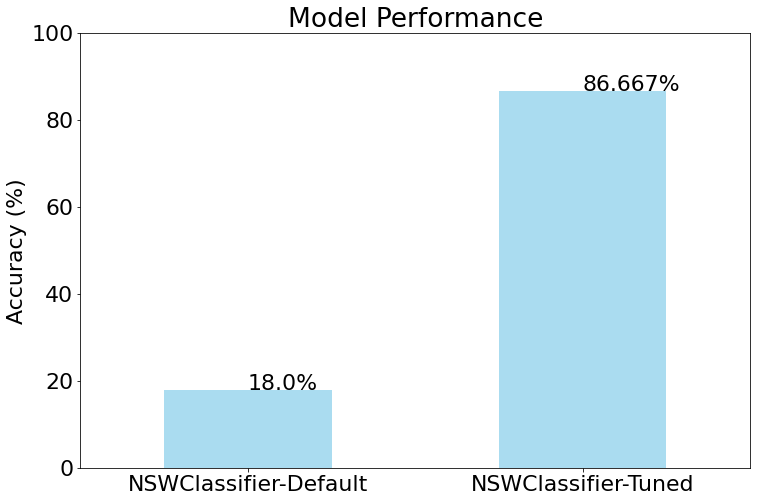

In [17]:
acc =  [acc_default*100,acc_tuned*100]
rows = ["NSWClassifier-Default", "NSWClassifier-Tuned"]

df = pd.DataFrame({"models": rows, "Accuracy":acc})

fig = plt.figure()
ax = df['Accuracy'].plot(kind="bar", figsize=(12, 8), alpha=0.7,
                 color=[
                     'skyblue'
                 ], label = "Accuracy")

ax.set_xticklabels(df['models'])
ax.set_ylabel("Accuracy (%)")

ax.set_ylim(0,100)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
for i,a in enumerate(acc):
    ax.text(i,a,str(round(a,3))+"%")
plt.text
plt.title("Model Performance")
plt.show()